## Code Organization

1. Data Preprocessing


*   Downloading data
*   Adding special tokens to the data
*   Padding
*   Building final tensor dataset

2. Model


*   Bi-LSTM

    *   Bi-LSTM (learning rate = 0.01, hidden dimension = 256, embedding dimension = 128)
    *   Bi-LSTM (learning rate = 0.05, hidden dimension = 256, embedding dimension = 128)
    *   Bi-LSTM (learning rate = 0.05, hidden dimension = 128, embedding dimension = 128)
    *   Bi-LSTM (learning rate = 0.05, hidden dimension = 128, embedding dimension = 256)

*   Bi-RNN
    *   Bi-RNN (learning rate = 0.01, hidden dimension = 256, embedding dimension = 128)
    *   Bi-RNN (learning rate = 0.05, hidden dimension = 256, embedding dimension = 128)
    *   Bi-RNN (learning rate = 0.05, hidden dimension = 128, embedding dimension = 128)
    *   Bi-RNN (learning rate = 0.05, hidden dimension = 128, embedding dimension = 256)







Required package: all neural network model constructions are using the package **pytorch**

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Preprocessing

## Downloading data

In [ ]:
import nltk
nltk.download('punkt')
from nltk import word_tokenize

nltk.download('treebank')
from nltk.corpus import treebank # training dataset

import numpy as np
from sklearn.model_selection import train_test_split
 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!


In [ ]:
# Retrieve tagged sentences from treebank corpus
tagged_sentences = nltk.corpus.treebank.tagged_sents()
 
print(tagged_sentences[0])
print("Tagged sentences: ", len(tagged_sentences))
print("Tagged words:", len(nltk.corpus.treebank.tagged_words()))
#tagged_words(): list of (str,str) tuple

[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')]
Tagged sentences:  3914
Tagged words: 100676


In [ ]:
sentences, sentence_tags =[], [] 
for tagged_sentence in tagged_sentences:
    #The zip() function returns a zip object, which is an iterator of tuples where the first item in each passed iterator is paired together, 
    #and then the second item in each passed iterator are paired together etc.
    sentence, tags = zip(*tagged_sentence)
    sentences.append(np.array(sentence)) # containing each word
    sentence_tags.append(np.array(tags)) # containing tags for each word
 
print(sentences[5])
print(sentence_tags[5])

['Lorillard' 'Inc.' ',' 'the' 'unit' 'of' 'New' 'York-based' 'Loews'
 'Corp.' 'that' '*T*-2' 'makes' 'Kent' 'cigarettes' ',' 'stopped' 'using'
 'crocidolite' 'in' 'its' 'Micronite' 'cigarette' 'filters' 'in' '1956'
 '.']
['NNP' 'NNP' ',' 'DT' 'NN' 'IN' 'JJ' 'JJ' 'NNP' 'NNP' 'WDT' '-NONE-' 'VBZ'
 'NNP' 'NNS' ',' 'VBD' 'VBG' 'NN' 'IN' 'PRP$' 'NN' 'NN' 'NNS' 'IN' 'CD'
 '.']


In [ ]:
# split into training and testing dataset with 20% in testing dataset
(train_sentences, 
 test_sentences, 
 train_tags, 
 test_tags) = train_test_split(sentences, sentence_tags, test_size=0.2, random_state = 42)

### Making vocabs with special tokens

*PAD: Padding*

*OOV: Out Of Vocabulary*

In [ ]:
words, tags = set([]), set([])
 
for s in train_sentences:
    for w in s:
        words.add(w.lower())

for ts in train_tags:
    for t in ts:
        tags.add(t)

word2index = {w: i + 2 for i, w in enumerate(list(words))} # create a dictionary where key is each word and corresponding value is the index for that word
word2index['-PAD-'] = 0  # The special value used for padding
word2index['-OOV-'] = 1  # The special value used for OOVs
 
tag2index = {t: i + 2 for i, t in enumerate(list(tags))} # similar as above (for tags)
tag2index['-PAD-'] = 0  # The special value used to tag padding
tag2index['-OOV-'] = 1  # The special value used to tag OOVs

In [ ]:
def encode_sentences(sentences):
    res = []
    for sent in sentences:
        temp = [word2index[word.lower()] if word.lower() in word2index else word2index['-OOV-'] for word in sent]
        res.append(temp)
    return res

# find the index created above for each word in the training and test dataset to encode them
train_sentences_encoded = encode_sentences(train_sentences)
test_sentences_encoded = encode_sentences(test_sentences)


train_tags_y, test_tags_y = [], []

def tag_to_index(tags_list):
    res = []
    for tags in tags_list:
        temp = [tag2index[tag] if tag in tag2index else tag2index['-OOV-'] for tag in tags]
        res.append(temp)
    return res

# similar as above (for tags)
train_tags_y = tag_to_index(train_tags)
test_tags_y = tag_to_index(test_tags)

### Padding

In [ ]:
# Pad to max_length
max_length = len(max(train_sentences_encoded, key=len))
print(max_length) 

271


In [ ]:
def pad_sequence(seq_list, max_length, index_dict):
    res = []
    for seq in seq_list:
        temp = seq[:]
        # if the sequence is longer than 271, then only take first 271 words
        if len(seq)>max_length:
            res.append(temp[:max_length])
        else:
        # if the sequence is shorter than 271, then add 'PAD' to make its length to 271
            temp += [index_dict['-PAD-']] * (max_length - len(seq))
            res.append(temp)
    return np.array(res)

train_sentences_encoded_pad = pad_sequence(train_sentences_encoded, max_length, word2index)
test_sentences_encoded_pad = pad_sequence(test_sentences_encoded, max_length, word2index)
train_tags_y_pad = pad_sequence(train_tags_y, max_length, tag2index)
test_tags_y_pad = pad_sequence(test_tags_y, max_length, tag2index)

### Build Dataset and Dataloader for training data

In [ ]:
from torch.utils.data import TensorDataset
# convert them to tensor
train_data = TensorDataset(torch.from_numpy(train_sentences_encoded_pad), torch.from_numpy(train_tags_y_pad))

from torch.utils.data import DataLoader

batch_size = 128
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True) 
# shuffle (bool, optional) – set to True to have the data reshuffled at every epoch (default: False).

# Model

# Bi-LSTM

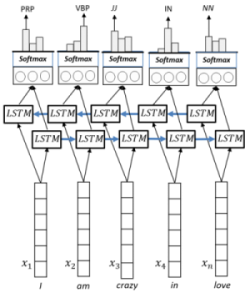

# Bi-LSTM (learning rate = 0.01, hidden_dim = 256, embedding_dim = 128）

In [ ]:
import torch.nn as nn

class LSTMTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim) # embedding layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True) # pass above embedding to bi-lstm layer
        self.hidden2tag = nn.Linear(hidden_dim * 2, tagset_size) # take output of above layer to a linear layer where the dimension squeeze from 2*hidden state to number of tags in the tag set

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence) # pass input sentence to embedding layer
        lstm_out, _ = self.lstm(embeds) # pass embedding to lstm layer (first output: all hidden states; second output: final hidden state )
        tag_space = self.hidden2tag(lstm_out) # pass lstm layer output to a linear layer (get the prediction) 
        return tag_space

EMBEDDING_DIM = 128
HIDDEN_DIM = 256

LSTM_model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word2index), len(tag2index)).to(device) # train the model
loss_function = nn.CrossEntropyLoss() # set up loss function
optimizer = torch.optim.Adam(LSTM_model.parameters(), lr=0.001) # set up optimizer

In [ ]:
loss_md1 = []
acc_md1 = []

In [ ]:
from sklearn.metrics import accuracy_score

number_epochs = 20

for epoch in range(number_epochs):  
    # initialize loss and accuracy
    loss_now = 0.0
    correct = 0

    for sentence,targets in train_loader:
        sentence = sentence.to(device)
        targets = targets.to(device)

        temp_batch_size = sentence.shape[0]

        LSTM_model.train()
        optimizer.zero_grad()   
        # pass sentence into model            
        tag_space = LSTM_model(sentence)
        # compare the output with largest probability with actual output
        loss = loss_function(tag_space.view(-1, tag_space.shape[-1]), targets.view(-1))
        # backproporgation
        loss.backward()
        optimizer.step()

        # update loss
        loss_now += loss.item() * temp_batch_size
        predicted = torch.argmax(tag_space, -1)
        # Note: The training accuracy here is calculated with "PAD", which will result in a relative higher accuracy.
        correct += accuracy_score(predicted.view(-1).cpu().numpy(),targets.view(-1).cpu().numpy())*temp_batch_size

    print('Epoch: %d, training loss: %.4f, training accuracy: %.2f%%'%(epoch+1,loss_now/len(train_data),100*correct/len(train_data)))
    loss_md1.append(loss_now/len(train_data))
    acc_md1.append(100*correct/len(train_data))

Epoch: 1, training loss: 0.7164, training accuracy: 87.31%
Epoch: 2, training loss: 0.3068, training accuracy: 93.19%
Epoch: 3, training loss: 0.2415, training accuracy: 94.09%
Epoch: 4, training loss: 0.2006, training accuracy: 94.91%
Epoch: 5, training loss: 0.1656, training accuracy: 95.69%
Epoch: 6, training loss: 0.1366, training accuracy: 96.43%
Epoch: 7, training loss: 0.1147, training accuracy: 96.93%
Epoch: 8, training loss: 0.0979, training accuracy: 97.36%
Epoch: 9, training loss: 0.0841, training accuracy: 97.71%
Epoch: 10, training loss: 0.0728, training accuracy: 98.02%
Epoch: 11, training loss: 0.0632, training accuracy: 98.29%
Epoch: 12, training loss: 0.0551, training accuracy: 98.53%
Epoch: 13, training loss: 0.0483, training accuracy: 98.72%
Epoch: 14, training loss: 0.0426, training accuracy: 98.87%
Epoch: 15, training loss: 0.0378, training accuracy: 99.00%
Epoch: 16, training loss: 0.0337, training accuracy: 99.11%
Epoch: 17, training loss: 0.0299, training accura

## Test with the test set

In [ ]:
LSTM_model.eval()
# convert test to torch
sentence = torch.from_numpy(test_sentences_encoded_pad).to(device)
# pass test set into model
tag_space = LSTM_model(sentence)
# get the predicted value as the one with highest probability
predicted = torch.argmax(tag_space, -1)
# convert to numpy
predicted = predicted.cpu().numpy()

# cut off the PAD part
test_len_list = [len(s) for s in test_sentences_encoded]
actual_predicted_list= []
for i in range(predicted.shape[0]):
    actual_predicted_list+=list(predicted[i])[:test_len_list[i]]

# get actual tag list
actual_tags = sum(test_tags_y, [])

print('Test Accuracy: %.2f%%'%(accuracy_score(actual_predicted_list,actual_tags)*100))

Test Accuracy: 88.70%


# Bi-LSTM (learning rate = 0.05, hidden_dim = 256, embedding_dim = 128)


In [ ]:
import torch.nn as nn

class LSTMTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim) # embedding layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True) # pass above embedding to bi-lstm layer
        self.hidden2tag = nn.Linear(hidden_dim * 2, tagset_size) # take output of above layer to a linear layer where the dimension squeeze from 2*hidden state to number of tags in the tag set

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence) # pass input sentence to embedding layer
        lstm_out, _ = self.lstm(embeds) # pass embedding to lstm layer (first output: all hidden states; second output: final hidden state )
        tag_space = self.hidden2tag(lstm_out) # pass lstm layer output to a linear layer (get the prediction) 
        return tag_space

EMBEDDING_DIM = 128
HIDDEN_DIM = 256

LSTM_model_1 = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word2index), len(tag2index)).to(device) # train the model
loss_function = nn.CrossEntropyLoss() # set up loss function
optimizer = torch.optim.Adam(LSTM_model_1.parameters(), lr=0.005) # set up optimizer

In [ ]:
loss_md2 = []
acc_md2 = []

In [ ]:
from sklearn.metrics import accuracy_score

number_epochs = 20

for epoch in range(number_epochs):  
    # initialize loss and accuracy
    loss_now = 0.0
    correct = 0

    for sentence,targets in train_loader:
        sentence = sentence.to(device)
        targets = targets.to(device)

        temp_batch_size = sentence.shape[0]

        LSTM_model_1.train()
        optimizer.zero_grad()   
        # pass sentence into model            
        tag_space = LSTM_model_1(sentence)
        # compare the output with largest probability with actual output
        loss = loss_function(tag_space.view(-1, tag_space.shape[-1]), targets.view(-1))
        # backproporgation
        loss.backward()
        optimizer.step()

        # update loss
        loss_now += loss.item() * temp_batch_size
        predicted = torch.argmax(tag_space, -1)
        # Note: The training accuracy here is calculated with "PAD", which will result in a relative higher accuracy.
        correct += accuracy_score(predicted.view(-1).cpu().numpy(),targets.view(-1).cpu().numpy())*temp_batch_size

    print('Epoch: %d, training loss: %.4f, training accuracy: %.2f%%'%(epoch+1,loss_now/len(train_data),100*correct/len(train_data)))
    loss_md2.append(loss_now/len(train_data))
    acc_md2.append(100*correct/len(train_data))

Epoch: 1, training loss: 0.4332, training accuracy: 89.44%
Epoch: 2, training loss: 0.1423, training accuracy: 96.13%
Epoch: 3, training loss: 0.0775, training accuracy: 97.83%
Epoch: 4, training loss: 0.0468, training accuracy: 98.69%
Epoch: 5, training loss: 0.0304, training accuracy: 99.17%
Epoch: 6, training loss: 0.0203, training accuracy: 99.47%
Epoch: 7, training loss: 0.0136, training accuracy: 99.66%
Epoch: 8, training loss: 0.0094, training accuracy: 99.78%
Epoch: 9, training loss: 0.0064, training accuracy: 99.87%
Epoch: 10, training loss: 0.0044, training accuracy: 99.92%
Epoch: 11, training loss: 0.0032, training accuracy: 99.95%
Epoch: 12, training loss: 0.0023, training accuracy: 99.97%
Epoch: 13, training loss: 0.0017, training accuracy: 99.98%
Epoch: 14, training loss: 0.0014, training accuracy: 99.99%
Epoch: 15, training loss: 0.0010, training accuracy: 99.99%
Epoch: 16, training loss: 0.0008, training accuracy: 99.99%
Epoch: 17, training loss: 0.0007, training accura

In [ ]:
LSTM_model_1.eval()
# convert test to torch
sentence = torch.from_numpy(test_sentences_encoded_pad).to(device)
# pass test set into model
tag_space = LSTM_model_1(sentence)
# get the predicted value as the one with highest probability
predicted = torch.argmax(tag_space, -1)
# convert to numpy
predicted = predicted.cpu().numpy()

# cut off the PAD part
test_len_list = [len(s) for s in test_sentences_encoded]
actual_predicted_list= []
for i in range(predicted.shape[0]):
    actual_predicted_list+=list(predicted[i])[:test_len_list[i]]

# get actual tag list
actual_tags = sum(test_tags_y, [])

print('Test Accuracy: %.2f%%'%(accuracy_score(actual_predicted_list,actual_tags)*100))

Test Accuracy: 91.99%


# Bi-LSTM (learning rate = 0.05, hidden_dim = 128, embedding_dim = 128)

In [ ]:
import torch.nn as nn

class LSTMTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim) # embedding layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True) # pass above embedding to bi-lstm layer
        self.dropout_layer = nn.Dropout(0.5) 
        self.hidden2tag = nn.Linear(hidden_dim * 2, tagset_size) # take output of above layer to a linear layer where the dimension squeeze from 2*hidden state to number of tags in the tag set

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence) # pass input sentence to embedding layer
        lstm_out, _ = self.lstm(embeds) # pass embedding to lstm layer (first output: all hidden states; second output: final hidden state )
        tag_space = self.hidden2tag(lstm_out) # pass lstm layer output to a linear layer (get the prediction) 
        return tag_space

EMBEDDING_DIM = 128
HIDDEN_DIM = 128

LSTM_model_3 = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word2index), len(tag2index)).to(device) # train the model
loss_function = nn.CrossEntropyLoss() # set up loss function
optimizer = torch.optim.Adam(LSTM_model_3.parameters(), lr=0.005) # set up optimizer

In [ ]:
loss_md3 = []
acc_md3 = []

In [ ]:
from sklearn.metrics import accuracy_score

number_epochs = 20

for epoch in range(number_epochs):  
    # initialize loss and accuracy
    loss_now = 0.0
    correct = 0

    for sentence,targets in train_loader:
        sentence = sentence.to(device)
        targets = targets.to(device)

        temp_batch_size = sentence.shape[0]

        LSTM_model_3.train()
        optimizer.zero_grad()   
        # pass sentence into model            
        tag_space = LSTM_model_3(sentence)
        # compare the output with largest probability with actual output
        loss = loss_function(tag_space.view(-1, tag_space.shape[-1]), targets.view(-1))
        # backproporgation
        loss.backward()
        optimizer.step()

        # update loss
        loss_now += loss.item() * temp_batch_size
        predicted = torch.argmax(tag_space, -1)
        # Note: The training accuracy here is calculated with "PAD", which will result in a relative higher accuracy.
        correct += accuracy_score(predicted.view(-1).cpu().numpy(),targets.view(-1).cpu().numpy())*temp_batch_size

    print('Epoch: %d, training loss: %.4f, training accuracy: %.2f%%'%(epoch+1,loss_now/len(train_data),100*correct/len(train_data)))
    loss_md3.append(loss_now/len(train_data))
    acc_md3.append(100*correct/len(train_data))

Epoch: 1, training loss: 0.5431, training accuracy: 88.52%
Epoch: 2, training loss: 0.1914, training accuracy: 95.10%
Epoch: 3, training loss: 0.1199, training accuracy: 96.81%
Epoch: 4, training loss: 0.0745, training accuracy: 98.06%
Epoch: 5, training loss: 0.0474, training accuracy: 98.78%
Epoch: 6, training loss: 0.0318, training accuracy: 99.20%
Epoch: 7, training loss: 0.0220, training accuracy: 99.47%
Epoch: 8, training loss: 0.0159, training accuracy: 99.64%
Epoch: 9, training loss: 0.0118, training accuracy: 99.74%
Epoch: 10, training loss: 0.0091, training accuracy: 99.81%
Epoch: 11, training loss: 0.0071, training accuracy: 99.85%
Epoch: 12, training loss: 0.0058, training accuracy: 99.89%
Epoch: 13, training loss: 0.0047, training accuracy: 99.91%
Epoch: 14, training loss: 0.0039, training accuracy: 99.93%
Epoch: 15, training loss: 0.0033, training accuracy: 99.94%
Epoch: 16, training loss: 0.0028, training accuracy: 99.95%
Epoch: 17, training loss: 0.0024, training accura

In [ ]:
LSTM_model_3.eval()
# convert test to torch
sentence = torch.from_numpy(test_sentences_encoded_pad).to(device)
# pass test set into model
tag_space = LSTM_model_3(sentence)
# get the predicted value as the one with highest probability
predicted = torch.argmax(tag_space, -1)
# convert to numpy
predicted = predicted.cpu().numpy()

# cut off the PAD part
test_len_list = [len(s) for s in test_sentences_encoded]
actual_predicted_list= []
for i in range(predicted.shape[0]):
    actual_predicted_list+=list(predicted[i])[:test_len_list[i]]

# get actual tag list
actual_tags = sum(test_tags_y, [])

print('Test Accuracy: %.2f%%'%(accuracy_score(actual_predicted_list,actual_tags)*100))

Test Accuracy: 91.18%


# Bi-LSTM (learning = 0.005, hidden_dim = 128, embedding_dim = 256)

In [ ]:
import torch.nn as nn

class LSTMTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim) # embedding layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True) # pass above embedding to bi-lstm layer
        self.dropout_layer = nn.Dropout(0.5) 
        self.hidden2tag = nn.Linear(hidden_dim * 2, tagset_size) # take output of above layer to a linear layer where the dimension squeeze from 2*hidden state to number of tags in the tag set

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence) # pass input sentence to embedding layer
        lstm_out, _ = self.lstm(embeds) # pass embedding to lstm layer (first output: all hidden states; second output: final hidden state )
        tag_space = self.hidden2tag(lstm_out) # pass lstm layer output to a linear layer (get the prediction) 
        return tag_space

EMBEDDING_DIM = 256
HIDDEN_DIM = 128

LSTM_model_4 = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word2index), len(tag2index)).to(device) # train the model
loss_function = nn.CrossEntropyLoss() # set up loss function
optimizer = torch.optim.Adam(LSTM_model_4.parameters(), lr=0.005) # set up optimizer

In [ ]:
loss_md4 = []
acc_md4 = []

In [ ]:
from sklearn.metrics import accuracy_score

number_epochs = 20

for epoch in range(number_epochs):  
    # initialize loss and accuracy
    loss_now = 0.0
    correct = 0

    for sentence,targets in train_loader:
        sentence = sentence.to(device)
        targets = targets.to(device)

        temp_batch_size = sentence.shape[0]

        LSTM_model_4.train()
        optimizer.zero_grad()   
        # pass sentence into model            
        tag_space = LSTM_model_4(sentence)
        # compare the output with largest probability with actual output
        loss = loss_function(tag_space.view(-1, tag_space.shape[-1]), targets.view(-1))
        # backproporgation
        loss.backward()
        optimizer.step()

        # update loss
        loss_now += loss.item() * temp_batch_size
        predicted = torch.argmax(tag_space, -1)
        # Note: The training accuracy here is calculated with "PAD", which will result in a relative higher accuracy.
        correct += accuracy_score(predicted.view(-1).cpu().numpy(),targets.view(-1).cpu().numpy())*temp_batch_size

    print('Epoch: %d, training loss: %.4f, training accuracy: %.2f%%'%(epoch+1,loss_now/len(train_data),100*correct/len(train_data)))
    loss_md4.append(loss_now/len(train_data))
    acc_md4.append(100*correct/len(train_data))

Epoch: 1, training loss: 0.4814, training accuracy: 89.40%
Epoch: 2, training loss: 0.1431, training accuracy: 96.36%
Epoch: 3, training loss: 0.0768, training accuracy: 98.07%
Epoch: 4, training loss: 0.0436, training accuracy: 98.90%
Epoch: 5, training loss: 0.0266, training accuracy: 99.36%
Epoch: 6, training loss: 0.0174, training accuracy: 99.61%
Epoch: 7, training loss: 0.0119, training accuracy: 99.74%
Epoch: 8, training loss: 0.0086, training accuracy: 99.82%
Epoch: 9, training loss: 0.0063, training accuracy: 99.88%
Epoch: 10, training loss: 0.0049, training accuracy: 99.91%
Epoch: 11, training loss: 0.0038, training accuracy: 99.94%
Epoch: 12, training loss: 0.0030, training accuracy: 99.95%
Epoch: 13, training loss: 0.0025, training accuracy: 99.96%
Epoch: 14, training loss: 0.0021, training accuracy: 99.97%
Epoch: 15, training loss: 0.0017, training accuracy: 99.98%
Epoch: 16, training loss: 0.0015, training accuracy: 99.98%
Epoch: 17, training loss: 0.0013, training accura

In [ ]:
LSTM_model_4.eval()
# convert test to torch
sentence = torch.from_numpy(test_sentences_encoded_pad).to(device)
# pass test set into model
tag_space = LSTM_model_4(sentence)
# get the predicted value as the one with highest probability
predicted = torch.argmax(tag_space, -1)
# convert to numpy
predicted = predicted.cpu().numpy()

# cut off the PAD part
test_len_list = [len(s) for s in test_sentences_encoded]
actual_predicted_list= []
for i in range(predicted.shape[0]):
    actual_predicted_list+=list(predicted[i])[:test_len_list[i]]

# get actual tag list
actual_tags = sum(test_tags_y, [])

print('Test Accuracy: %.2f%%'%(accuracy_score(actual_predicted_list,actual_tags)*100))

Test Accuracy: 91.00%


# Bi-RNN

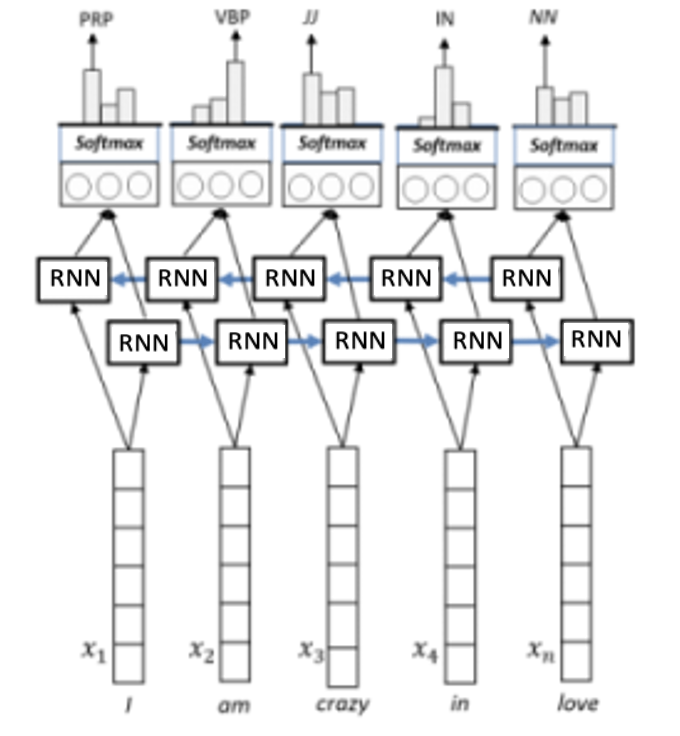

# Bi-RNN (learning rate = 0.01, hidden_dim = 256, embedding_dim = 128)

In [ ]:
import torch.nn as nn

class RNNTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(RNNTagger, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim) # embedding layer
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True, bidirectional=True) # pass above embedding to bi-rnn layer
        self.hidden2tag = nn.Linear(hidden_dim * 2, tagset_size) # take output of above layer to a linear layer where the dimension squeeze from 2*hidden state to number of tags in the tag set

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence) # pass input sentence to embedding layer
        rnn_out, _ = self.rnn(embeds) # pass embedding to rnn layer (first output: all hidden states; second output: final hidden state )
        tag_space = self.hidden2tag(rnn_out) # pass rnn layer output to a linear layer (get the prediction) 
        return tag_space

EMBEDDING_DIM = 128
HIDDEN_DIM = 256

RNN_model = RNNTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word2index), len(tag2index)).to(device) # train the model
loss_function = nn.CrossEntropyLoss() # set up loss function
optimizer = torch.optim.Adam(RNN_model.parameters(), lr=0.001) # set up optimizer

In [ ]:
loss_md5 = []
acc_md5 = []

In [ ]:
from sklearn.metrics import accuracy_score

number_epochs = 20

for epoch in range(number_epochs):  
    # initialize loss and accuracy
    loss_now = 0.0
    correct = 0

    for sentence,targets in train_loader:
        sentence = sentence.to(device)
        targets = targets.to(device)

        # use full-batch training
        temp_batch_size = sentence.shape[0]

        RNN_model.train()
        optimizer.zero_grad()   
        # pass sentence into model            
        tag_space = RNN_model(sentence)
        # compare the output with largest probability with actual output
        loss = loss_function(tag_space.view(-1, tag_space.shape[-1]), targets.view(-1))
        # backproporgation
        loss.backward()
        optimizer.step()

        # update loss
        loss_now += loss.item() * temp_batch_size
        predicted = torch.argmax(tag_space, -1)
        # Note: The training accuracy here is calculated with "PAD", which will result in a relative higher accuracy.
        correct += accuracy_score(predicted.view(-1).cpu().numpy(),targets.view(-1).cpu().numpy())*temp_batch_size

    print('Epoch: %d, training loss: %.4f, training accuracy: %.2f%%'%(epoch+1,loss_now/len(train_data),100*correct/len(train_data)))
    loss_md5.append(loss_now/len(train_data))
    acc_md5.append(100*correct/len(train_data))

Epoch: 1, training loss: 0.5824, training accuracy: 88.34%
Epoch: 2, training loss: 0.2339, training accuracy: 94.43%
Epoch: 3, training loss: 0.1783, training accuracy: 95.39%
Epoch: 4, training loss: 0.1484, training accuracy: 96.15%
Epoch: 5, training loss: 0.1266, training accuracy: 96.69%
Epoch: 6, training loss: 0.1098, training accuracy: 97.09%
Epoch: 7, training loss: 0.0960, training accuracy: 97.43%
Epoch: 8, training loss: 0.0845, training accuracy: 97.72%
Epoch: 9, training loss: 0.0747, training accuracy: 97.98%
Epoch: 10, training loss: 0.0664, training accuracy: 98.21%
Epoch: 11, training loss: 0.0592, training accuracy: 98.40%
Epoch: 12, training loss: 0.0530, training accuracy: 98.58%
Epoch: 13, training loss: 0.0476, training accuracy: 98.72%
Epoch: 14, training loss: 0.0429, training accuracy: 98.85%
Epoch: 15, training loss: 0.0388, training accuracy: 98.97%
Epoch: 16, training loss: 0.0353, training accuracy: 99.07%
Epoch: 17, training loss: 0.0320, training accura

In [ ]:
RNN_model.eval()
# convert test to torch
sentence = torch.from_numpy(test_sentences_encoded_pad).to(device)
# pass test set into model
tag_space = RNN_model(sentence)
# get the predicted value as the one with highest probability
predicted = torch.argmax(tag_space, -1)
# convert to numpy
predicted = predicted.cpu().numpy()

# cut off the PAD part
test_len_list = [len(s) for s in test_sentences_encoded]
actual_predicted_list= []
for i in range(predicted.shape[0]):
    actual_predicted_list+=list(predicted[i])[:test_len_list[i]]

# get actual tag list
actual_tags = sum(test_tags_y, [])

print('Test Accuracy: %.2f%%'%(accuracy_score(actual_predicted_list,actual_tags)*100))

Test Accuracy: 88.39%


# Bi-RNN (learning rate = 0.05, hidden_dim = 256, embedding_dim = 128)



In [ ]:
import torch.nn as nn

class RNNTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(RNNTagger, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim) # embedding layer
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True, bidirectional=True) # pass above embedding to bi-rnn layer
        self.hidden2tag = nn.Linear(hidden_dim * 2, tagset_size) # take output of above layer to a linear layer where the dimension squeeze from 2*hidden state to number of tags in the tag set

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence) # pass input sentence to embedding layer
        rnn_out, _ = self.rnn(embeds) # pass embedding to rnn layer (first output: all hidden states; second output: final hidden state )
        tag_space = self.hidden2tag(rnn_out) # pass rnn layer output to a linear layer (get the prediction) 
        return tag_space

EMBEDDING_DIM = 128
HIDDEN_DIM = 256

RNN_model_1 = RNNTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word2index), len(tag2index)).to(device) # train the model
loss_function = nn.CrossEntropyLoss() # set up loss function
optimizer = torch.optim.Adam(RNN_model_1.parameters(), lr=0.005) # set up optimizer

In [ ]:
loss_md6 = []
acc_md6 = []

In [ ]:
from sklearn.metrics import accuracy_score

number_epochs = 20

for epoch in range(number_epochs):  
    # initialize loss and accuracy
    loss_now = 0.0
    correct = 0

    for sentence,targets in train_loader:
        sentence = sentence.to(device)
        targets = targets.to(device)

        # use full-batch training
        temp_batch_size = sentence.shape[0]

        RNN_model_1.train()
        optimizer.zero_grad()   
        # pass sentence into model            
        tag_space = RNN_model_1(sentence)
        # compare the output with largest probability with actual output
        loss = loss_function(tag_space.view(-1, tag_space.shape[-1]), targets.view(-1))
        # backproporgation
        loss.backward()
        optimizer.step()

        # update loss
        loss_now += loss.item() * temp_batch_size
        predicted = torch.argmax(tag_space, -1)
        # Note: The training accuracy here is calculated with "PAD", which will result in a relative higher accuracy.
        correct += accuracy_score(predicted.view(-1).cpu().numpy(),targets.view(-1).cpu().numpy())*temp_batch_size

    print('Epoch: %d, training loss: %.4f, training accuracy: %.2f%%'%(epoch+1,loss_now/len(train_data),100*correct/len(train_data)))
    loss_md6.append(loss_now/len(train_data))
    acc_md6.append(100*correct/len(train_data))

Epoch: 1, training loss: 0.3746, training accuracy: 90.63%
Epoch: 2, training loss: 0.1076, training accuracy: 97.00%
Epoch: 3, training loss: 0.0669, training accuracy: 98.10%
Epoch: 4, training loss: 0.0430, training accuracy: 98.81%
Epoch: 5, training loss: 0.0288, training accuracy: 99.21%
Epoch: 6, training loss: 0.0198, training accuracy: 99.47%
Epoch: 7, training loss: 0.0138, training accuracy: 99.64%
Epoch: 8, training loss: 0.0099, training accuracy: 99.76%
Epoch: 9, training loss: 0.0072, training accuracy: 99.84%
Epoch: 10, training loss: 0.0053, training accuracy: 99.89%
Epoch: 11, training loss: 0.0040, training accuracy: 99.92%
Epoch: 12, training loss: 0.0031, training accuracy: 99.94%
Epoch: 13, training loss: 0.0024, training accuracy: 99.96%
Epoch: 14, training loss: 0.0019, training accuracy: 99.97%
Epoch: 15, training loss: 0.0015, training accuracy: 99.98%
Epoch: 16, training loss: 0.0012, training accuracy: 99.99%
Epoch: 17, training loss: 0.0010, training accura

In [ ]:
RNN_model_1.eval()
# convert test to torch
sentence = torch.from_numpy(test_sentences_encoded_pad).to(device)
# pass test set into model
tag_space = RNN_model_1(sentence)
# get the predicted value as the one with highest probability
predicted = torch.argmax(tag_space, -1)
# convert to numpy
predicted = predicted.cpu().numpy()

# cut off the PAD part
test_len_list = [len(s) for s in test_sentences_encoded]
actual_predicted_list= []
for i in range(predicted.shape[0]):
    actual_predicted_list+=list(predicted[i])[:test_len_list[i]]

# get actual tag list
actual_tags = sum(test_tags_y, [])

print('Test Accuracy: %.2f%%'%(accuracy_score(actual_predicted_list,actual_tags)*100))

Test Accuracy: 91.48%


# Bi-RNN (learning rate = 0.05, hidden_dim = 128, embedding_dim = 128)

In [ ]:
import torch.nn as nn

class RNNTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(RNNTagger, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim) # embedding layer
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True, bidirectional=True) # pass above embedding to bi-rnn layer
        self.hidden2tag = nn.Linear(hidden_dim * 2, tagset_size) # take output of above layer to a linear layer where the dimension squeeze from 2*hidden state to number of tags in the tag set

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence) # pass input sentence to embedding layer
        rnn_out, _ = self.rnn(embeds) # pass embedding to rnn layer (first output: all hidden states; second output: final hidden state )
        tag_space = self.hidden2tag(rnn_out) # pass rnn layer output to a linear layer (get the prediction) 
        return tag_space

EMBEDDING_DIM = 128
HIDDEN_DIM = 128

RNN_model_2 = RNNTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word2index), len(tag2index)).to(device) # train the model
loss_function = nn.CrossEntropyLoss() # set up loss function
optimizer = torch.optim.Adam(RNN_model_2.parameters(), lr=0.005) # set up optimizer

In [ ]:
loss_md7 = []
acc_md7 = []

In [ ]:
from sklearn.metrics import accuracy_score

number_epochs = 20

for epoch in range(number_epochs):  
    # initialize loss and accuracy
    loss_now = 0.0
    correct = 0

    for sentence,targets in train_loader:
        sentence = sentence.to(device)
        targets = targets.to(device)

        # use full-batch training
        temp_batch_size = sentence.shape[0]

        RNN_model_2.train()
        optimizer.zero_grad()   
        # pass sentence into model            
        tag_space = RNN_model_2(sentence)
        # compare the output with largest probability with actual output
        loss = loss_function(tag_space.view(-1, tag_space.shape[-1]), targets.view(-1))
        # backproporgation
        loss.backward()
        optimizer.step()

        # update loss
        loss_now += loss.item() * temp_batch_size
        predicted = torch.argmax(tag_space, -1)
        # Note: The training accuracy here is calculated with "PAD", which will result in a relative higher accuracy.
        correct += accuracy_score(predicted.view(-1).cpu().numpy(),targets.view(-1).cpu().numpy())*temp_batch_size

    print('Epoch: %d, training loss: %.4f, training accuracy: %.2f%%'%(epoch+1,loss_now/len(train_data),100*correct/len(train_data)))
    loss_md7.append(loss_now/len(train_data))
    acc_md7.append(100*correct/len(train_data))

Epoch: 1, training loss: 0.4634, training accuracy: 89.30%
Epoch: 2, training loss: 0.1479, training accuracy: 96.03%
Epoch: 3, training loss: 0.0957, training accuracy: 97.44%
Epoch: 4, training loss: 0.0648, training accuracy: 98.29%
Epoch: 5, training loss: 0.0445, training accuracy: 98.86%
Epoch: 6, training loss: 0.0314, training accuracy: 99.21%
Epoch: 7, training loss: 0.0230, training accuracy: 99.44%
Epoch: 8, training loss: 0.0172, training accuracy: 99.59%
Epoch: 9, training loss: 0.0133, training accuracy: 99.69%
Epoch: 10, training loss: 0.0105, training accuracy: 99.76%
Epoch: 11, training loss: 0.0085, training accuracy: 99.81%
Epoch: 12, training loss: 0.0070, training accuracy: 99.85%
Epoch: 13, training loss: 0.0059, training accuracy: 99.88%
Epoch: 14, training loss: 0.0050, training accuracy: 99.89%
Epoch: 15, training loss: 0.0043, training accuracy: 99.91%
Epoch: 16, training loss: 0.0037, training accuracy: 99.93%
Epoch: 17, training loss: 0.0033, training accura

In [ ]:
RNN_model_2.eval()
# convert test to torch
sentence = torch.from_numpy(test_sentences_encoded_pad).to(device)
# pass test set into model
tag_space = RNN_model_2(sentence)
# get the predicted value as the one with highest probability
predicted = torch.argmax(tag_space, -1)
# convert to numpy
predicted = predicted.cpu().numpy()

# cut off the PAD part
test_len_list = [len(s) for s in test_sentences_encoded]
actual_predicted_list= []
for i in range(predicted.shape[0]):
    actual_predicted_list+=list(predicted[i])[:test_len_list[i]]

# get actual tag list
actual_tags = sum(test_tags_y, [])

print('Test Accuracy: %.2f%%'%(accuracy_score(actual_predicted_list,actual_tags)*100))

Test Accuracy: 91.99%


# Bi-RNN (learning rate = 0.05, hidden_dim = 128, embedding_dim = 256)

In [ ]:
import torch.nn as nn

class RNNTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(RNNTagger, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim) # embedding layer
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True, bidirectional=True) # pass above embedding to bi-rnn layer
        self.hidden2tag = nn.Linear(hidden_dim * 2, tagset_size) # take output of above layer to a linear layer where the dimension squeeze from 2*hidden state to number of tags in the tag set

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence) # pass input sentence to embedding layer
        rnn_out, _ = self.rnn(embeds) # pass embedding to rnn layer (first output: all hidden states; second output: final hidden state )
        tag_space = self.hidden2tag(rnn_out) # pass rnn layer output to a linear layer (get the prediction) 
        return tag_space

EMBEDDING_DIM = 256
HIDDEN_DIM = 128

RNN_model_3 = RNNTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word2index), len(tag2index)).to(device) # train the model
loss_function = nn.CrossEntropyLoss() # set up loss function
optimizer = torch.optim.Adam(RNN_model_3.parameters(), lr=0.005) # set up optimizer

In [ ]:
loss_md8 = []
acc_md8 = []

In [ ]:
from sklearn.metrics import accuracy_score

number_epochs = 20

for epoch in range(number_epochs):  
    # initialize loss and accuracy
    loss_now = 0.0
    correct = 0

    for sentence,targets in train_loader:
        sentence = sentence.to(device)
        targets = targets.to(device)

        # use full-batch training
        temp_batch_size = sentence.shape[0]

        RNN_model_3.train()
        optimizer.zero_grad()   
        # pass sentence into model            
        tag_space = RNN_model_3(sentence)
        # compare the output with largest probability with actual output
        loss = loss_function(tag_space.view(-1, tag_space.shape[-1]), targets.view(-1))
        # backproporgation
        loss.backward()
        optimizer.step()

        # update loss
        loss_now += loss.item() * temp_batch_size
        predicted = torch.argmax(tag_space, -1)
        # Note: The training accuracy here is calculated with "PAD", which will result in a relative higher accuracy.
        correct += accuracy_score(predicted.view(-1).cpu().numpy(),targets.view(-1).cpu().numpy())*temp_batch_size

    print('Epoch: %d, training loss: %.4f, training accuracy: %.2f%%'%(epoch+1,loss_now/len(train_data),100*correct/len(train_data)))
    loss_md8.append(loss_now/len(train_data))
    acc_md8.append(100*correct/len(train_data))

Epoch: 1, training loss: 0.4213, training accuracy: 90.38%
Epoch: 2, training loss: 0.1104, training accuracy: 97.07%
Epoch: 3, training loss: 0.0623, training accuracy: 98.36%
Epoch: 4, training loss: 0.0383, training accuracy: 99.02%
Epoch: 5, training loss: 0.0250, training accuracy: 99.37%
Epoch: 6, training loss: 0.0172, training accuracy: 99.58%
Epoch: 7, training loss: 0.0124, training accuracy: 99.71%
Epoch: 8, training loss: 0.0093, training accuracy: 99.79%
Epoch: 9, training loss: 0.0072, training accuracy: 99.84%
Epoch: 10, training loss: 0.0058, training accuracy: 99.87%
Epoch: 11, training loss: 0.0047, training accuracy: 99.90%
Epoch: 12, training loss: 0.0040, training accuracy: 99.92%
Epoch: 13, training loss: 0.0034, training accuracy: 99.93%
Epoch: 14, training loss: 0.0029, training accuracy: 99.94%
Epoch: 15, training loss: 0.0025, training accuracy: 99.95%
Epoch: 16, training loss: 0.0021, training accuracy: 99.96%
Epoch: 17, training loss: 0.0019, training accura

In [ ]:
RNN_model_3.eval()
# convert test to torch
sentence = torch.from_numpy(test_sentences_encoded_pad).to(device)
# pass test set into model
tag_space = RNN_model_3(sentence)
# get the predicted value as the one with highest probability
predicted = torch.argmax(tag_space, -1)
# convert to numpy
predicted = predicted.cpu().numpy()

# cut off the PAD part
test_len_list = [len(s) for s in test_sentences_encoded]
actual_predicted_list= []
for i in range(predicted.shape[0]):
    actual_predicted_list+=list(predicted[i])[:test_len_list[i]]

# get actual tag list
actual_tags = sum(test_tags_y, [])

print('Test Accuracy: %.2f%%'%(accuracy_score(actual_predicted_list,actual_tags)*100))

Test Accuracy: 91.87%


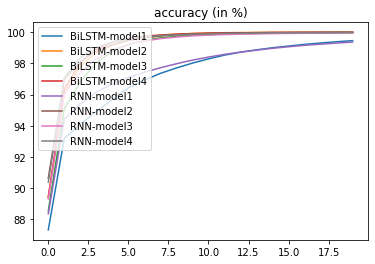

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(20)
plt.plot(x, acc_md1)
plt.plot(x, acc_md2)
plt.plot(x, acc_md3)
plt.plot(x, acc_md4)
plt.plot(x, acc_md5)
plt.plot(x, acc_md6)
plt.plot(x, acc_md7)
plt.plot(x, acc_md8)
plt.legend(['BiLSTM-model1', 'BiLSTM-model2','BiLSTM-model3', 'BiLSTM-model4','RNN-model1', 'RNN-model2','RNN-model3', 'RNN-model4'], loc='upper left')
plt.title("accuracy (in %)")
plt.show()

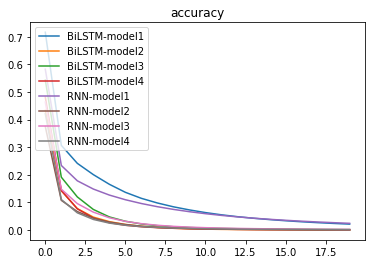

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(20)
plt.plot(x, loss_md1)
plt.plot(x, loss_md2)
plt.plot(x, loss_md3)
plt.plot(x, loss_md4)
plt.plot(x, loss_md5)
plt.plot(x, loss_md6)
plt.plot(x, loss_md7)
plt.plot(x, loss_md8)
plt.legend(['BiLSTM-model1', 'BiLSTM-model2','BiLSTM-model3', 'BiLSTM-model4','RNN-model1', 'RNN-model2','RNN-model3', 'RNN-model4'], loc='upper left')
plt.title("loss")
plt.show()